In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio
import math

In [59]:

data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})


data = sio.loadmat('mnist_binary_small.mat')
Xtrain = data['Xtrain']
Xtest = data['Xtest']
ytrain = data['ytrain'][0,:]
ytest = data['ytest'][0,:]

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)


(1958, 784) (1991, 784) (1958,) (1991,)


In [60]:
def get_weighted_misclass(w,y,yhat):
    return (sum(w * (np.not_equal(y, yhat)).astype(int)))/sum(w)
    #finds the error rate of a weak classifier 
    
def get_misclass(y,yhat):
    return (np.sum(np.not_equal(y,yhat)) / len(y))
    # see's how many you are matching and gets the % of whats that match

def get_exp_loss(y,yhat):
    return np.mean(np.exp(-y * yhat))
    #exponetional loss formula

aTree = tree.DecisionTreeClassifier(max_depth=1) #creating a decision tree
aTree.fit(Xtrain, ytrain) #X train is a matrix, y Train is a vector

predictionXTest = aTree.predict(Xtest)
predictionXTrain = aTree.predict(Xtrain)

test_misclass = get_misclass(ytest, predictionXTest)
train_misclass = get_misclass( ytrain, predictionXTrain)
train_expo = get_exp_loss(ytrain, predictionXTrain)
print("Train misclassification is " + str(round(train_misclass*100, 2)) + '%', "test misclasification is " + str(round(test_misclass*100, 2)) + '%',str(round(train_expo,2)) + " exponential loss")



Train misclassification is 10.98% test misclasification is 15.27% 0.63 exponential loss


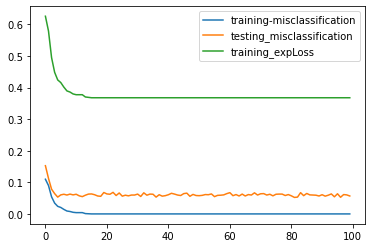

min train classification rate: 0.0 %
min test classification rate: 5.22 %
min exponential loss: 0.3678794411714424


In [61]:
trainRates, testRates, expLosses = [], [], []

for m in range(1, 101):
    clf = tree.DecisionTreeClassifier(max_depth=m)
    clf.fit(Xtrain, ytrain)
    trainRates.append(get_misclass(ytrain, clf.predict(Xtrain)))
    testRates.append(get_misclass(ytest, clf.predict(Xtest)))
    expLosses.append(get_exp_loss(ytrain, clf.predict(Xtrain)))

plt.plot(trainRates)
plt.plot(testRates)
plt.plot(expLosses)
training = ["training-misclassification","testing_misclassification", "training_expLoss"]

plt.legend(training)
plt.show()

print("min train classification rate:", round(min(trainRates)*100, 2),"%")
print("min test classification rate:", round(min(testRates)*100,2),"%")
print("min exponential loss:", min(expLosses))

In [62]:
def get_weighted_misclass_For_Adaboost(w,y,yhat):
    return (sum(w * (np.not_equal(y, yhat)).astype(int)))/sum(w)
    #finds the error rate of a weak classifier 

def update(error):
    return (1/2) * np.log((1 - error) / error)

def update_weights(w, update, y, yhat):
    return w * np.exp(update * (np.not_equal(y, yhat)).astype(int))

wetrain, wetest  = np.ones(len(ytrain)) / len(ytrain), np.ones(len(ytest)) / len(ytest) #initializing
theExpLoss, trainingMisclassifications, testingMisclassifications, alphaWeightTrains, alphaWeightTests = [], [], [], [], []

stump = tree.DecisionTreeClassifier(max_depth = 1)
stump.fit(Xtrain, ytrain, sample_weight = wetrain)
predicationXTrain = stump.predict(Xtrain)
    
stump.fit(Xtest, ytest, sample_weight = wetest)
predicationXTest = stump.predict(Xtest)

errorMisclassRateTrain = get_weighted_misclass_For_Adaboost(wetrain, ytrain, predicationXTrain) #gets weighted misclassification error rate in training
errorMisclassRateTest = get_weighted_misclass_For_Adaboost(wetest, ytest, predicationXTest) #gets weighted misclassification error rate in testing

trainingMisclassifications.append(errorMisclassRateTrain)
testingMisclassifications.append(errorMisclassRateTest)

alphaTrain = update(errorMisclassRateTrain)
alphaTest = update(errorMisclassRateTest)
    
alphaWeightTrains.append(alphaTrain)
alphaWeightTests.append(alphaTest)

theExpLoss.append(get_exp_loss(ytrain, predicationXTrain))

for m in range(1, 101):
    wetrain = update_weights(wetrain, alphaTrain, ytrain, predicationXTrain)
    wetest = update_weights(wetest, alphaTest, ytest, predicationXTest)

    stump = tree.DecisionTreeClassifier(max_depth = 1)
    stump.fit(Xtrain, ytrain, sample_weight = wetrain)
    predicationXTrain = stump.predict(Xtrain)
    
    stump.fit(Xtest, ytest, sample_weight = wetest)
    predicationXTest = stump.predict(Xtest)

    errorMisclassRateTrain = get_weighted_misclass_For_Adaboost(wetrain, ytrain, predicationXTrain) #gets weighted misclassification error rate in training
    errorMisclassRateTest = get_weighted_misclass_For_Adaboost(wetest, ytest, predicationXTest) #gets weighted misclassification error rate in testing

    trainingMisclassifications.append(errorMisclassRateTrain)
    testingMisclassifications.append(errorMisclassRateTest)

    alphaTrain = update(errorMisclassRateTrain)
    alphaTest = update(errorMisclassRateTest)
    
    alphaWeightTrains.append(alphaTrain)
    alphaWeightTests.append(alphaTest)

    theExpLoss.append(get_exp_loss(ytrain, predicationXTrain))

minimum Training misclassification 0.10980592441266993
minimum Testing misclassification 0.1496735308889984
minimum Exponential Loss 0.6259675480492947


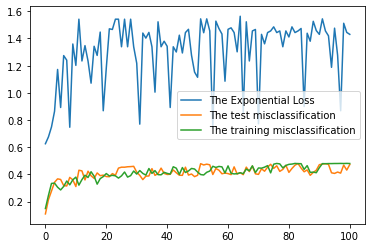

In [63]:

plt.plot(theExpLoss, label = "The Exponential Loss")
plt.plot(trainingMisclassifications, label = "The test misclassification")
plt.plot(testingMisclassifications, label = "The training misclassification")
plt.legend()

print("minimum Training misclassification", min(trainingMisclassifications))
print("minimum Testing misclassification", min(testingMisclassifications))
print("minimum Exponential Loss", min(theExpLoss))
#Question : the boosting decision tree did not perform as well as the deep trees because
#deep creates create large trees up to a depth of 100 and the boosting we were doing did not
#make up the difference in accuracy (Deep trees are more accurate) Exponential loss is lower


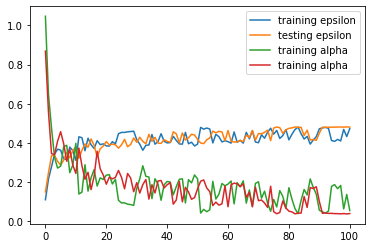

In [64]:
plt.plot(trainingMisclassifications, label="training epsilon")
plt.plot(testingMisclassifications, label="testing epsilon")
plt.plot(alphaWeightTrains, label="training alpha")
plt.plot(alphaWeightTests, label="training alpha")
plt.legend()
#Question : 